In [232]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats

folder_path = os.path.join('project_data', 'bonds')
bgrn_plots = os.path.join('plots', 'bgrn')

ticker = "BGRN"
print(f"Downloading {ticker}...")

try:
    bgrn = yf.download(ticker, period="max", progress=False)
    
    print(f"Downloaded {len(bgrn)} records from {bgrn.index[0].date()} to {bgrn.index[-1].date()}")
    
    file_path = os.path.join(folder_path, f'{ticker}_data.csv')
    bgrn.to_csv(file_path)
        
except Exception as e:
    print(f"Error: {e}")

C:\Users\Mykhailo\AppData\Local\Temp\ipykernel_6984\578880669.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bgrn = yf.download(ticker, period="max", progress=False)


Downloaded 1658 records from 2018-11-27 to 2025-07-03


In [233]:
print(f"Columns: {list(bgrn.columns)}")
print(f"Shape: {bgrn.shape}")

Columns: [('Close', 'BGRN'), ('High', 'BGRN'), ('Low', 'BGRN'), ('Open', 'BGRN'), ('Volume', 'BGRN')]
Shape: (1658, 5)


In [234]:
print("First 5 rows:")
print(bgrn.head())

print("\nLast 5 rows:")
print(bgrn.tail())

print("\nMissing values:")
print(bgrn.isnull().sum())

price_col = "Close"

print(f"\nPrice statistics:")
print(bgrn[price_col].describe())

First 5 rows:
Price           Close       High        Low       Open Volume
Ticker           BGRN       BGRN       BGRN       BGRN   BGRN
Date                                                         
2018-11-27  41.616810  41.616810  41.616810  41.616810    400
2018-11-28  41.554676  41.583674  41.554676  41.563791   1100
2018-11-29  41.554676  41.554676  41.554676  41.554676      0
2018-11-30  41.684761  41.684761  41.684761  41.684761    200
2018-12-03  41.684761  41.684761  41.684761  41.684761      0

Last 5 rows:
Price           Close       High        Low       Open Volume
Ticker           BGRN       BGRN       BGRN       BGRN   BGRN
Date                                                         
2025-06-27  47.333595  47.453174  47.315657  47.315657  17800
2025-06-30  47.502998  47.512965  47.355518  47.433244  19300
2025-07-01  47.480000  47.523998  47.410000  47.509998  21000
2025-07-02  47.509998  47.509998  47.380001  47.419998  23600
2025-07-03  47.400002  47.590000  47.34999

Plot saved to plots\bgrn\BGRN_price_plot.png


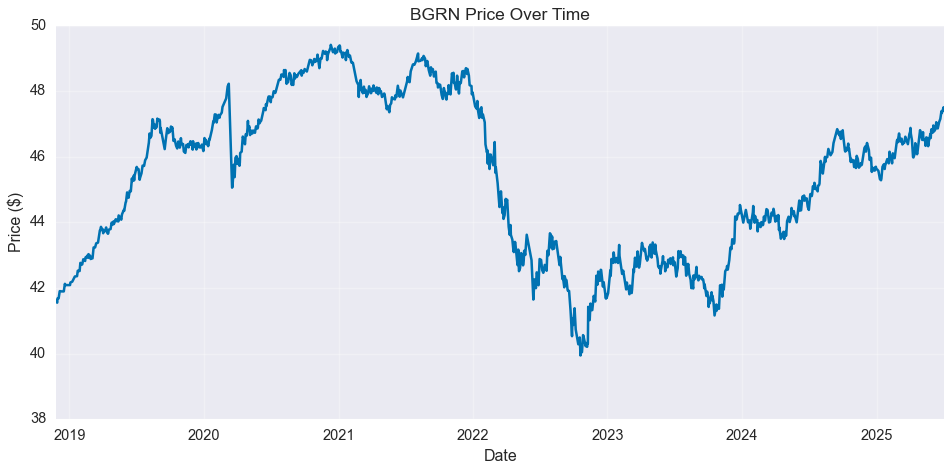

In [235]:
plt.figure(figsize=(12, 6))
plt.plot(bgrn.index, bgrn[price_col])
plt.title(f'{ticker} Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plot_path = os.path.join(bgrn_plots, f'{ticker}_price_plot.png')
plt.savefig(plot_path)
print(f"Plot saved to {plot_path}")

plt.show()

This resources is helpfull: https://gregorygundersen.com/blog/2022/02/06/log-returns/

I have to analyze the log returns of the stock prices of BGRN further on. 

There is also an idea to make some P-P plots comparing different indices.

Volume plot saved to plots\bgrn\BGRN_volume_plot


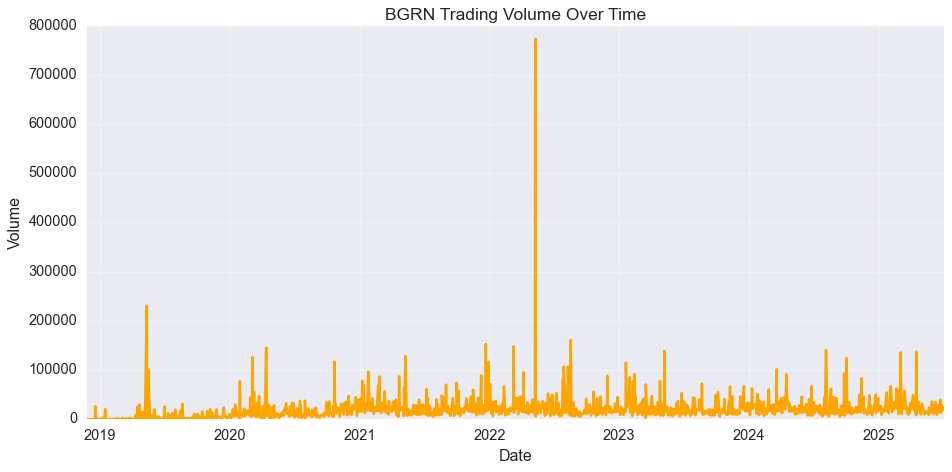

In [236]:
volume_col = 'Volume'

plt.figure(figsize=(12, 6))
plt.plot(bgrn.index, bgrn[volume_col], color='orange')
plt.title(f'BGRN Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plot_path = os.path.join(bgrn_plots, f'BGRN_volume_plot')
plt.savefig(plot_path)
print(f"Volume plot saved to {plot_path}")

plt.show()

**TODO** Explore the outliers.

In [237]:
bgrn_returns = bgrn_common[price_col].pct_change().dropna()
bgrn_volume = bgrn_common['Volume'].dropna()

amihud_illiquidity = (abs(bgrn_returns) / bgrn_volume * 1e6)
avg_illiquidity = amihud_illiquidity.mean()

avg_daily_volume = bgrn_volume.mean()
volume_volatility = bgrn_volume.std() / bgrn_volume.mean()  # Coefficient of variation

zero_return_days = (abs(bgrn_returns) < 0.001).sum()
zero_return_pct = zero_return_days / len(bgrn_returns) * 100

volume_trend = np.polyfit(range(len(bgrn_volume)), bgrn_volume, 1)[0]

print(f"Average Daily Volume: {avg_daily_volume['BGRN']:,.0f}")
print(f"Volume Volatility (CV): {volume_volatility['BGRN']:.2f}")
print(f"Amihud Illiquidity Ratio: {avg_illiquidity['BGRN']:.6f}")
print(f"Zero-return days: {zero_return_pct['BGRN']:.1f}%")
print(f"Volume trend (daily increase): {volume_trend[0]:,.0f}")
print()

if avg_illiquidity['BGRN'] > 1:
    print("HIGH illiquidity - still niche market characteristics")
elif avg_illiquidity['BGRN'] > 0.1:
    print("MODERATE illiquidity - transitioning market")
else:
    print("LOW illiquidity - mainstream market characteristics")

if zero_return_pct['BGRN'] > 5:
    print("High inactive trading days - limited institutional participation")
elif zero_return_pct['BGRN'] > 2:
    print("Moderate inactive days - growing but not mainstream")
else:
    print("Low inactive days - active institutional market")

if volume_trend[0] > 0:
    print(f"INCREASING volume trend - market mainstreaming (trend: +{volume_trend[0]:,.0f}/day)")
else:
    print(f"DECREASING volume trend - market consolidation")

Average Daily Volume: 20,045
Volume Volatility (CV): 1.33
Amihud Illiquidity Ratio: 0.340058
Zero-return days: 29.7%
Volume trend (daily increase): 11

MODERATE illiquidity - transitioning market
High inactive trading days - limited institutional participation
INCREASING volume trend - market mainstreaming (trend: +11/day)


Plot saved to plots\bgrn\BGRN_liquidity_analysis.png


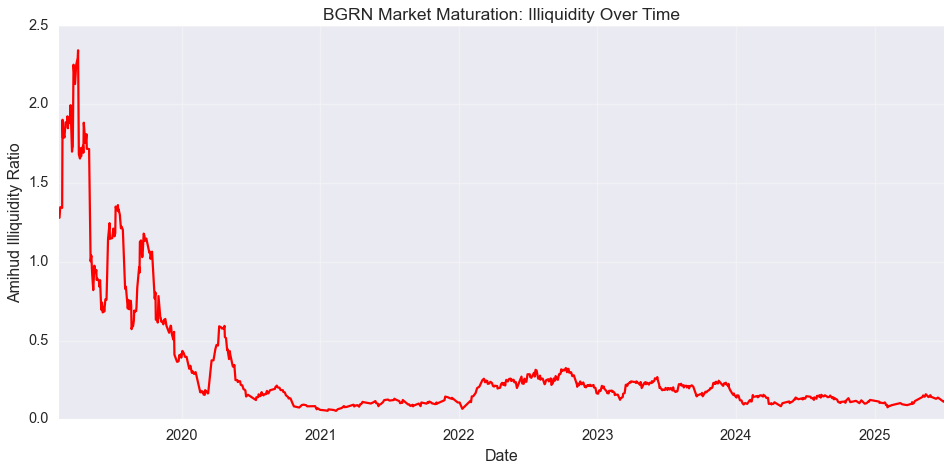

In [238]:
illiquidity_smooth = amihud_illiquidity.rolling(30).mean().dropna()

plt.figure(figsize=(12, 6))
plt.plot(illiquidity_smooth.index, illiquidity_smooth, color='red', linewidth=2)
plt.ylabel('Amihud Illiquidity Ratio')
plt.xlabel('Date')
plt.title('BGRN Market Maturation: Illiquidity Over Time')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plot_path = os.path.join(bgrn_plots, 'BGRN_liquidity_analysis.png')
plt.savefig(plot_path)
print(f"Plot saved to {plot_path}")

plt.show()

Plot saved to plots\bgrn\BGRN_volume_analysis.png


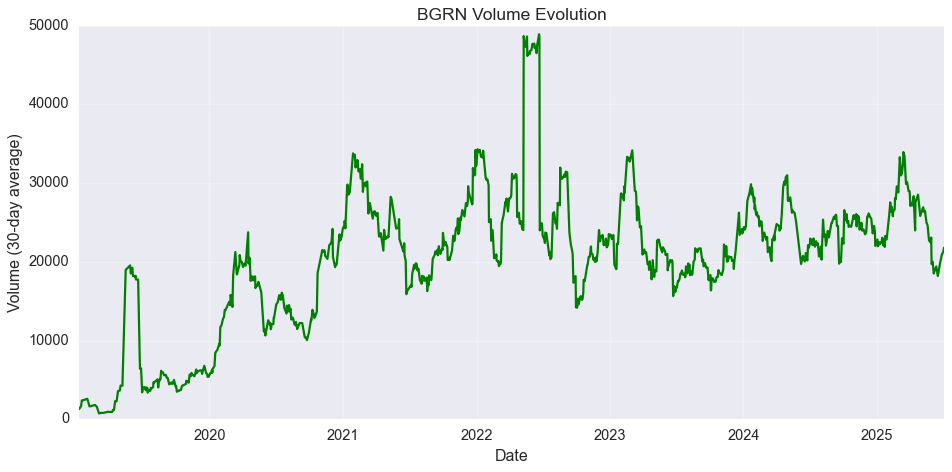

In [239]:
volume_smooth = bgrn_volume.rolling(30).mean().dropna()

plt.figure(figsize=(12, 6))
plt.plot(volume_smooth.index, volume_smooth, color='green', linewidth=2)
plt.ylabel('Volume (30-day average)')
plt.xlabel('Date')
plt.title('BGRN Volume Evolution')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plot_path = os.path.join(bgrn_plots, 'BGRN_volume_analysis.png')
plt.savefig(plot_path)
print(f"Plot saved to {plot_path}")

plt.show()

In [240]:
if illiquidity_smooth.iloc[-1, 0] < illiquidity_smooth.iloc[0, 0]:
    print("Liquidity has IMPROVED over time - suggesting market maturation")
else:
    print("Liquidity has WORSENED over time - market remains niche")

recent_volume = volume_smooth.iloc[-252:].mean()
early_volume = volume_smooth.iloc[:252].mean()
volume_growth = (recent_volume / early_volume - 1) * 100

print(f"Illiquidity reduction: {illiquidity_smooth.iloc[0, 0]:.1f} => {illiquidity_smooth.iloc[-1, 0]:.1f}")
print(f"Volume peak vs current: {volume_smooth.max().iloc[0]:,.0f} vs {volume_smooth.iloc[-1, 0]:,.0f}")
print(f"Volume growth: {volume_growth.iloc[0]:.0f}% from early period to recent period")

Liquidity has IMPROVED over time - suggesting market maturation
Illiquidity reduction: 1.3 => 0.1
Volume peak vs current: 48,897 vs 21,790
Volume growth: 346% from early period to recent period


Volume plot saved to plots\bgrn\BGRN_price_distribution


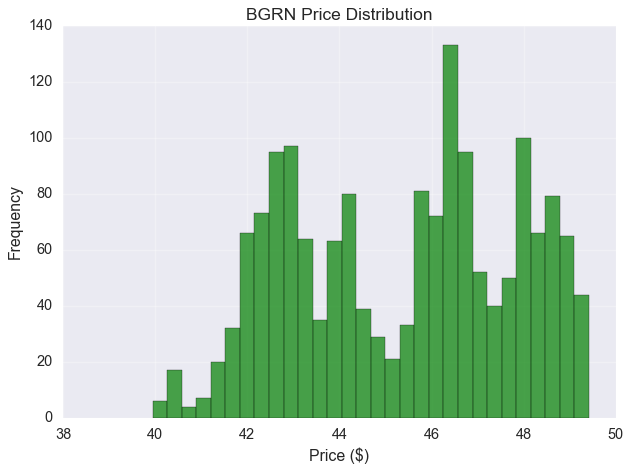

In [241]:
plt.figure(figsize=(8, 6))
plt.hist(bgrn[price_col], bins=30, alpha=0.7, color='green')
plt.title(f'{ticker} Price Distribution')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plot_path = os.path.join(bgrn_plots, f'BGRN_price_distribution')
plt.savefig(plot_path)
print(f"Volume plot saved to {plot_path}")

plt.show()

Most common price range is located around $46-47. Presumably, because of several significant secondary peaks, the stock has had different preffered price levels at different times. In general, the spread shows the stock's typical trading range.

Plot saved to plots\bgrn\BGRN_daily_price_range.png


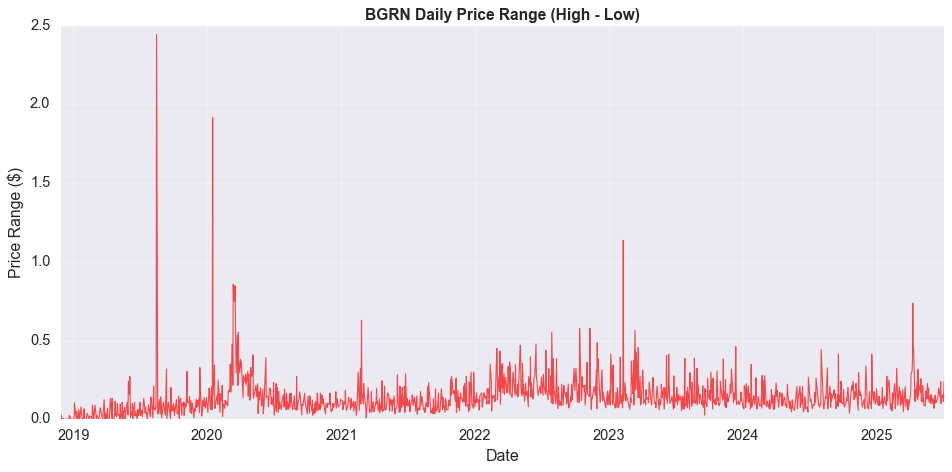

In [242]:
bgrn_daily_range = bgrn['High'] - bgrn['Low']

plt.figure(figsize=(12, 6))

plt.plot(bgrn.index, bgrn_daily_range, linewidth=1, color='red', alpha=0.7)
plt.title('BGRN Daily Price Range (High - Low)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price Range ($)')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plot_path = os.path.join(bgrn_plots, 'BGRN_daily_price_range.png')
plt.savefig(plot_path)
print(f"Plot saved to {plot_path}")

plt.show()

**TODO** What these visible price range shocks could possibly indicate?

In [243]:
daily_returns = bgrn[price_col].pct_change().dropna()
annual_volatility = daily_returns.std() * np.sqrt(252)

print(f"BGRN annual volatility: {annual_volatility['BGRN']:.1%}")

BGRN annual volatility: 5.2%


Let's calculate the annual volatility of our stock. For that we need to find daily returns and calculate respective standart deviation which gives us the daily volatility. Then by applying square root of time rule we'll be able to find annual volatility. 

https://gregorygundersen.com/blog/2022/05/24/square-root-of-time-rule/


Also in this article, author is actively trying to prove that low-volatility stocks can outperform in the long run the high-volatility stocks. 

https://blogs.cfainstitute.org/investor/2024/02/16/the-low-volatility-factor-and-occams-razor/



In [244]:
avg_daily_change = abs(daily_returns).mean()
print(f"Average daily price movement: {avg_daily_change['BGRN']:.2%}")

Average daily price movement: 0.24%


In [245]:
print("Downloading benchmark data...")

benchmark_indices = ["SPY", "SPLV"]

spy = yf.download(benchmark_indices[0], period="max", progress=False)
splv = yf.download(benchmark_indices[1], period="max", progress=False)

spy.to_csv(os.path.join(folder_path, f'{benchmark_indices[0]}_data.csv'))
splv.to_csv(os.path.join(folder_path, f'{benchmark_indices[1]}_data.csv'))

print(f"{benchmark_indices[0]}: {len(spy)} records from {spy.index[0].date()} to {spy.index[-1].date()}")
print(f"{benchmark_indices[1]}: {len(splv)} records from {splv.index[0].date()} to {splv.index[-1].date()}")

C:\Users\Mykhailo\AppData\Local\Temp\ipykernel_6984\1569303940.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download(benchmark_indices[0], period="max", progress=False)
C:\Users\Mykhailo\AppData\Local\Temp\ipykernel_6984\1569303940.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  splv = yf.download(benchmark_indices[1], period="max", progress=False)


SPY: 8163 records from 1993-01-29 to 2025-07-03
SPLV: 3562 records from 2011-05-05 to 2025-07-03


In [246]:
common_start = max(bgrn.index[0], spy.index[0], splv.index[0])
common_end = min(bgrn.index[-1], spy.index[-1], splv.index[-1])

print(f"Comparing over common period: {common_start.date()} to {common_end.date()}")

bgrn_common = bgrn[common_start:common_end]
spy_common = spy[common_start:common_end]
splv_common = splv[common_start:common_end]

bgrn_returns = bgrn_common[price_col].pct_change().dropna()
spy_returns = spy_common[price_col].pct_change().dropna()
splv_returns = splv_common[price_col].pct_change().dropna()

bgrn_vol = bgrn_returns.std() * np.sqrt(252)
spy_vol = spy_returns.std() * np.sqrt(252)
splv_vol = splv_returns.std() * np.sqrt(252)

bgrn_daily = abs(bgrn_returns).mean()
spy_daily = abs(spy_returns).mean()
splv_daily = abs(splv_returns).mean()

print(f"Period: {len(bgrn_returns)} trading days")
print()
print("Annual Volatility:")
print(f"BGRN (ESG ETF):           {bgrn_vol['BGRN']:.2%}")
print(f"SPY (S&P 500):            {spy_vol['SPY']:.2%}")
print(f"SPLV (S&P 500 Low Vol):   {splv_vol['SPLV']:.2%}")
print()
print("Average Daily Movement:")
print(f"BGRN:  {bgrn_daily['BGRN']:.2%}")
print(f"SPY:   {spy_daily['SPY']:.2%}")
print(f"SPLV:  {splv_daily['SPLV']:.2%}")
print()
print(f"BGRN vs SPY: {bgrn_vol['BGRN']/spy_vol['SPY']:.2f}x the volatility")
print(f"BGRN vs SPLV: {bgrn_vol['BGRN']/splv_vol['SPLV']:.2f}x the volatility")
print(f"SPLV vs SPY: {splv_vol['SPLV']/spy_vol['SPY']:.2f}x the volatility")

Comparing over common period: 2018-11-27 to 2025-07-03
Period: 1657 trading days

Annual Volatility:
BGRN (ESG ETF):           5.22%
SPY (S&P 500):            20.44%
SPLV (S&P 500 Low Vol):   17.62%

Average Daily Movement:
BGRN:  0.24%
SPY:   0.84%
SPLV:  0.68%

BGRN vs SPY: 0.26x the volatility
BGRN vs SPLV: 0.30x the volatility
SPLV vs SPY: 0.86x the volatility


In [247]:
from hurst import compute_Hc

def interpret_hurst(hurst_value):
    if hurst_value > 0.55:
        return "TRENDING / PERSISTENT behavior"
    elif hurst_value < 0.45:
        return "MEAN-REVERTING behavior"
    else:
        return "RANDOM WALK behavior"

etfs = [("BGRN", bgrn), ("AGG", agg), ("LQD", lqd), ("TLT", tlt), ("HYG", hyg)]
hurst_results = {}

for name, data in etfs:
    returns = data[price_col].pct_change().dropna().values
    hurst_val, _, _ = compute_Hc(returns)
    hurst_results[name] = hurst_val
    print(f"{name}: {hurst_val:.3f} - {interpret_hurst(hurst_val)}")

BGRN: 0.306 - MEAN-REVERTING behavior
AGG: 0.378 - MEAN-REVERTING behavior
LQD: 0.404 - MEAN-REVERTING behavior
TLT: 0.247 - MEAN-REVERTING behavior
HYG: 0.369 - MEAN-REVERTING behavior


In [248]:
hurst_bgrn = hurst_results["BGRN"]
other_hursts = [val for key, val in hurst_results.items() if key != "BGRN"]
avg_others = np.mean(other_hursts)
difference = abs(hurst_bgrn - avg_others)

print(f"\nBGRN vs Traditional Bond Assets Average: {hurst_bgrn:.3f} vs {avg_others:.3f}")
print(f"Difference: {difference:.3f}")

if difference > 0.1:
    print("SIGNIFICANT difference - BGRN has unique market dynamics")
    print("Supports 'distinct asset class' hypothesis")
else:
    print("SIMILAR dynamics - BGRN behaving like traditional bond assets")
    print("Suggests market integration/mainstreaming")


BGRN vs Traditional Bond Assets Average: 0.306 vs 0.350
Difference: 0.044
SIMILAR dynamics - BGRN behaving like traditional bond assets
Suggests market integration/mainstreaming


Plot saved to plots\bgrn\comparison_price_plot.png


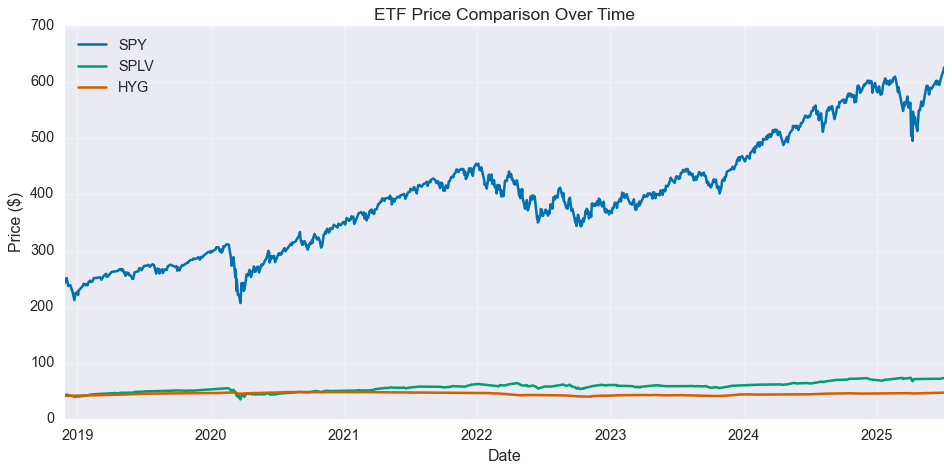

In [267]:
plt.figure(figsize=(12, 6))

plt.plot(spy_common.index, spy_common[price_col], label=benchmark_indices[0])
plt.plot(splv_common.index, splv_common[price_col], label=benchmark_indices[1])
plt.plot(bgrn.index, bgrn[price_col], label=ticker)

plt.title("ETF Price Comparison Over Time")
plt.xlabel('Date')
plt.ylabel('Price ($)')

plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plot_path = os.path.join(bgrn_plots, 'comparison_price_plot.png')
plt.savefig(plot_path)
print(f"Plot saved to {plot_path}")

plt.show()

Plot saved to plots\bgrn\normalized_comparison_price_plot.png


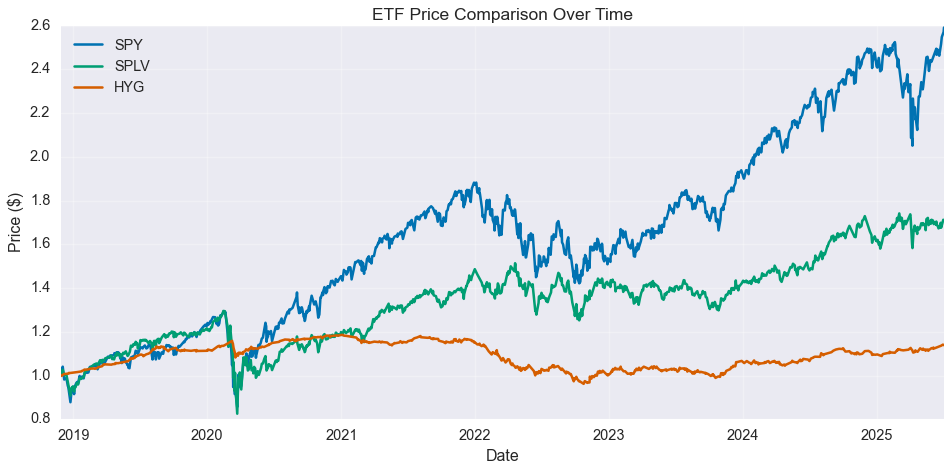

In [268]:
spy_norm = spy_common[price_col] / spy_common[price_col].iloc[0]
splv_norm = splv_common[price_col] / splv_common[price_col].iloc[0]
bgrn_norm = bgrn[price_col] / bgrn[price_col].iloc[0]

plt.figure(figsize=(12, 6))

plt.plot(spy_common.index, spy_norm, label=benchmark_indices[0])
plt.plot(splv_common.index, splv_norm, label=benchmark_indices[1])
plt.plot(bgrn_common.index, bgrn_norm, label=ticker)

plt.title("ETF Price Comparison Over Time")
plt.xlabel('Date')
plt.ylabel('Price ($)')

plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plot_path = os.path.join(bgrn_plots, 'normalized_comparison_price_plot.png')
plt.savefig(plot_path)
print(f"Plot saved to {plot_path}")

plt.show()

As we can see, BGRN shows minimal price movement. It can be compared to SPLV, which performs better in terms of returns. However, the explnation though is quite simple: BGRN is a bond ETF, while SPY and SPLV are stock ETFs. That's why BGRN has much lower price fluctuations and volatility.

https://www.ishares.com/us/products/305296/ishares-usd-green-bond-etf

Then let's perform a benchmarking analysis of the BGRN compared to other bonds.

In [251]:
agg = yf.download("AGG", period="max", progress=False)  # Total Bond Market
lqd = yf.download("LQD", period="max", progress=False)  # Investment Grade Corporate
tlt = yf.download("TLT", period="max", progress=False)  # Long-Term Treasury
hyg = yf.download("HYG", period="max", progress=False)  # High Yield (for contrast)

for ticker, data in [("AGG", agg), ("LQD", lqd), ("TLT", tlt), ("HYG", hyg)]:
    data.to_csv(os.path.join(folder_path, f'{ticker}_data.csv'))
    print(f"{ticker}: {len(data)} records from {data.index[0].date()} to {data.index[-1].date()}")

C:\Users\Mykhailo\AppData\Local\Temp\ipykernel_6984\1100330799.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  agg = yf.download("AGG", period="max", progress=False)  # Total Bond Market
C:\Users\Mykhailo\AppData\Local\Temp\ipykernel_6984\1100330799.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  lqd = yf.download("LQD", period="max", progress=False)  # Investment Grade Corporate
C:\Users\Mykhailo\AppData\Local\Temp\ipykernel_6984\1100330799.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tlt = yf.download("TLT", period="max", progress=False)  # Long-Term Treasury
C:\Users\Mykhailo\AppData\Local\Temp\ipykernel_6984\1100330799.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  hyg = yf.download("HYG", period="max", progress=False)  # High Yield (for contrast)


AGG: 5476 records from 2003-09-29 to 2025-07-03
LQD: 5770 records from 2002-07-30 to 2025-07-03
TLT: 5770 records from 2002-07-30 to 2025-07-03
HYG: 4588 records from 2007-04-11 to 2025-07-03


AGG includes over 10,000 U.S.-issued fixed income securities, ranging from Treasury bonds and mortgage-backed securities (MBS) to investment-grade corporate debt. It basically represents the entire bond ETF market.

LQD represents corporate bonds from financially stable companies with high credit ratings. It reflects the performance of investment-grade corporate debt as a more specific segment of the market.

TLT consists of long-term U.S. government bonds that are highly sensitive to interest rate changes. It allows for observing how long-duration government bonds behave under changing macroeconomic conditions.

HYG contains high-yield, or “junk,” corporate bonds with higher risk and potentially higher returns. It captures the behavior of the riskiest part of the bond market for comparison.

In [252]:
common_start = max(bgrn.index[0], agg.index[0], lqd.index[0], tlt.index[0], hyg.index[0])
common_end = min(bgrn.index[-1], agg.index[-1], lqd.index[-1], tlt.index[-1], hyg.index[-1])

bond_data = {}
for name, df in [("BGRN", bgrn), ("AGG", agg), ("LQD", lqd), ("TLT", tlt), ("HYG", hyg)]:
    bond_data[name] = df[common_start:common_end][price_col]

bond_prices = pd.concat(bond_data.values(), axis=1)
bond_prices.columns = bond_data.keys()

print(f"Analysis period: {common_start.date()} to {common_end.date()}")
print(f"Total observations: {len(bond_prices)}")


Analysis period: 2018-11-27 to 2025-07-03
Total observations: 1658


Plot saved to plots\bgrn\bond_comparison_price_plot.png


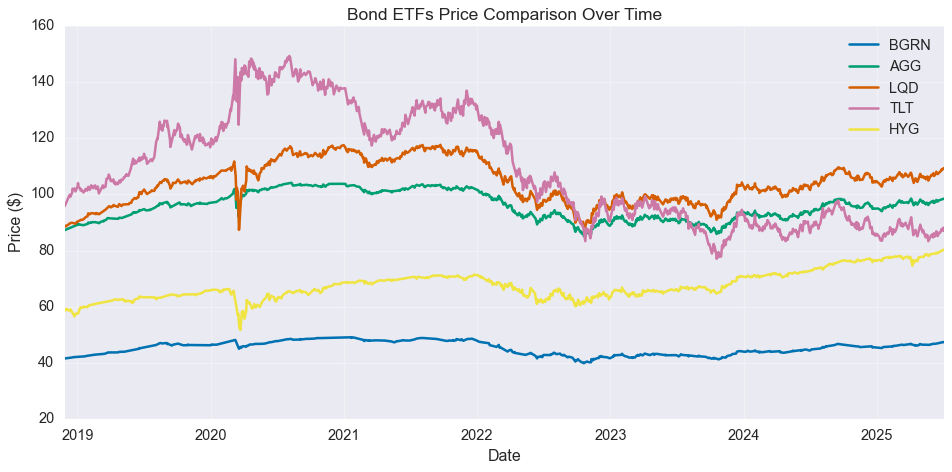

In [253]:
plt.figure(figsize=(12, 6))

plt.plot(bond_prices.index, bond_prices['BGRN'], label='BGRN')
plt.plot(bond_prices.index, bond_prices['AGG'], label='AGG')
plt.plot(bond_prices.index, bond_prices['LQD'], label='LQD')
plt.plot(bond_prices.index, bond_prices['TLT'], label='TLT')
plt.plot(bond_prices.index, bond_prices['HYG'], label='HYG')

plt.title("Bond ETFs Price Comparison Over Time")
plt.xlabel('Date')
plt.ylabel('Price ($)')

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plot_path = os.path.join(bgrn_plots, 'bond_comparison_price_plot.png')
plt.savefig(plot_path)
print(f"Plot saved to {plot_path}")

plt.show()

Plot saved to plots\bgrn\normalized_bond_comparison_price_plot.png


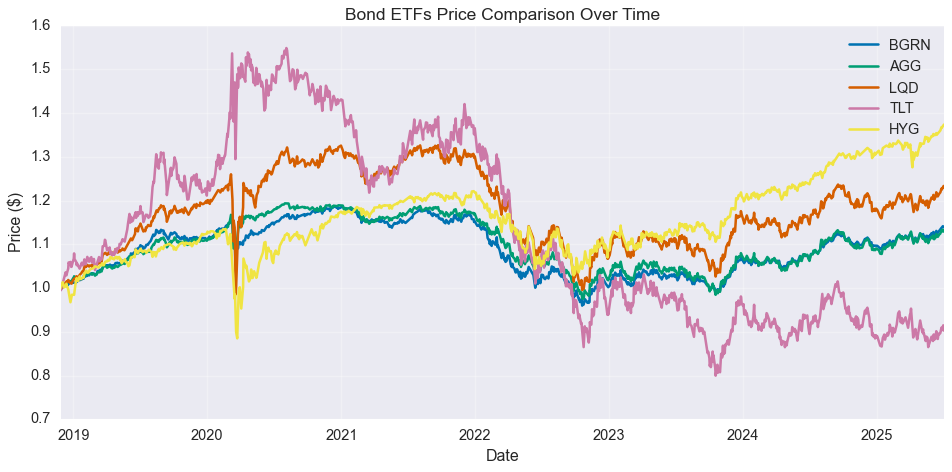

In [254]:
bond_norm = bond_prices / bond_prices.iloc[0]


plt.figure(figsize=(12, 6))

plt.plot(bond_norm.index, bond_norm['BGRN'], label='BGRN')
plt.plot(bond_norm.index, bond_norm['AGG'], label='AGG')
plt.plot(bond_norm.index, bond_norm['LQD'], label='LQD')
plt.plot(bond_norm.index, bond_norm['TLT'], label='TLT')
plt.plot(bond_norm.index, bond_norm['HYG'], label='HYG')

plt.title("Bond ETFs Price Comparison Over Time")
plt.xlabel('Date')
plt.ylabel('Price ($)')

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plot_path = os.path.join(bgrn_plots, 'normalized_bond_comparison_price_plot.png')
plt.savefig(plot_path)
print(f"Plot saved to {plot_path}")

plt.show()

There appears to be a strong correlation between BGRN and AGG. I need to investigate this further. In general, it showed neither the best nor the worst results in terms of price changes throughout the years. BGRN exhibits typical behaviour for a bond ETF.

Plot saved to plots\bgrn\bond_daily_returns_comparison_price_plot.png


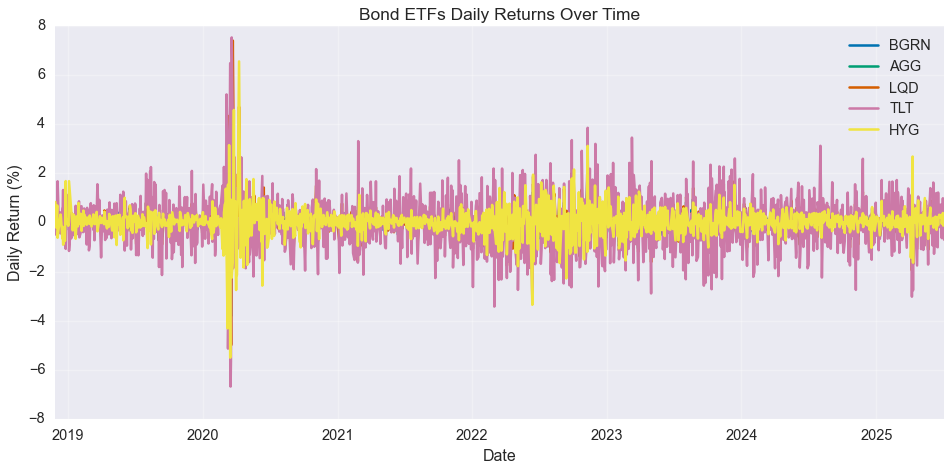

In [255]:
bond_returns = bond_prices.pct_change().dropna() * 100

plt.figure(figsize=(12, 6))

plt.plot(bond_returns.index, bond_returns['BGRN'], label='BGRN')
plt.plot(bond_returns.index, bond_returns['AGG'], label='AGG')
plt.plot(bond_returns.index, bond_returns['LQD'], label='LQD')
plt.plot(bond_returns.index, bond_returns['TLT'], label='TLT')
plt.plot(bond_returns.index, bond_returns['HYG'], label='HYG')

plt.title("Bond ETFs Daily Returns Over Time")
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plot_path = os.path.join(bgrn_plots, 'bond_daily_returns_comparison_price_plot.png')
plt.savefig(plot_path)
print(f"Plot saved to {plot_path}")

plt.show()

Plot saved to plots\bgrn\BGRN_AGG_daily_returns_comparison_price_plot.png


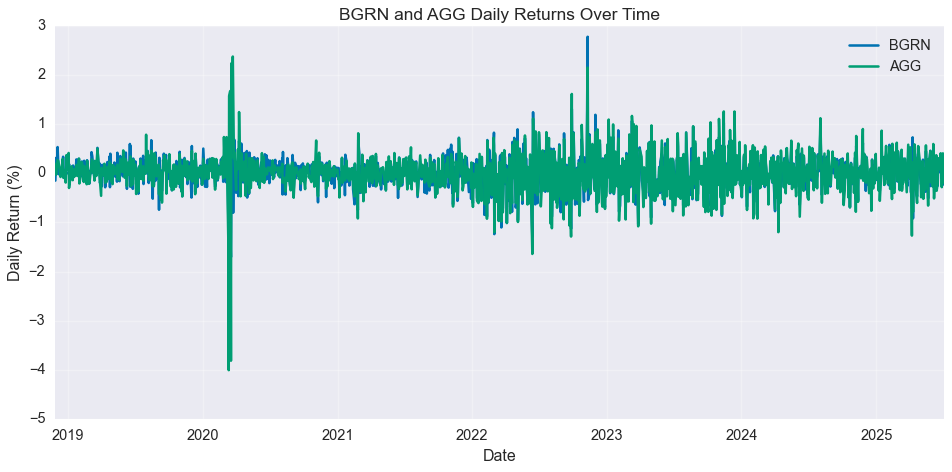

In [256]:
plt.figure(figsize=(12, 6))

plt.plot(bond_returns.index, bond_returns['BGRN'], label='BGRN')
plt.plot(bond_returns.index, bond_returns['AGG'], label='AGG')

plt.title("BGRN and AGG Daily Returns Over Time")
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plot_path = os.path.join(bgrn_plots, 'BGRN_AGG_daily_returns_comparison_price_plot.png')
plt.savefig(plot_path)
print(f"Plot saved to {plot_path}")

plt.show()

Plot saved to plots\bgrn\BGRN_daily_returns_comparison_price_plot.png


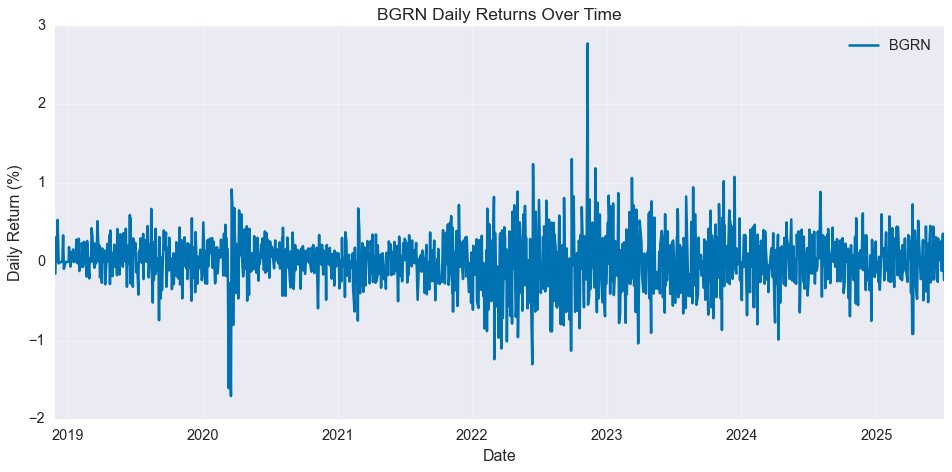

In [257]:
plt.figure(figsize=(12, 6))

plt.plot(bond_returns.index, bond_returns['BGRN'], label='BGRN')

plt.title("BGRN Daily Returns Over Time")
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plot_path = os.path.join(bgrn_plots, 'BGRN_daily_returns_comparison_price_plot.png')
plt.savefig(plot_path)
print(f"Plot saved to {plot_path}")

plt.show()

Plot saved to plots\bgrn\BGRN_rolling_volatility_plot.png


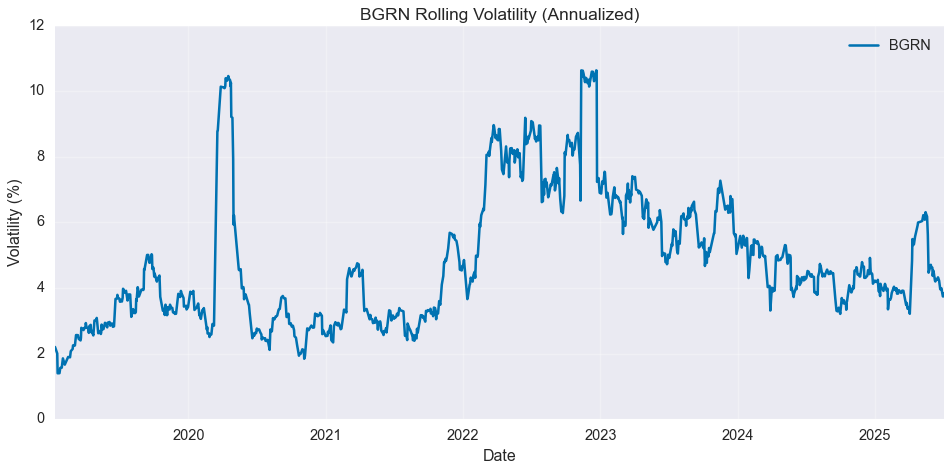

In [270]:
plt.figure(figsize=(12, 6))

plt.plot(bond_returns.index, bond_returns['BGRN'].rolling(window=30).std() * np.sqrt(252), label='BGRN')

plt.title("BGRN Rolling Volatility (Annualized)")
plt.xlabel('Date')
plt.ylabel('Volatility (%)')

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plot_path = os.path.join(bgrn_plots, 'BGRN_rolling_volatility_plot.png')
plt.savefig(plot_path)
print(f"Plot saved to {plot_path}")

plt.show()

Plot saved to plots\bgrn\bond_weekly_returns_comparison_price_plot.png


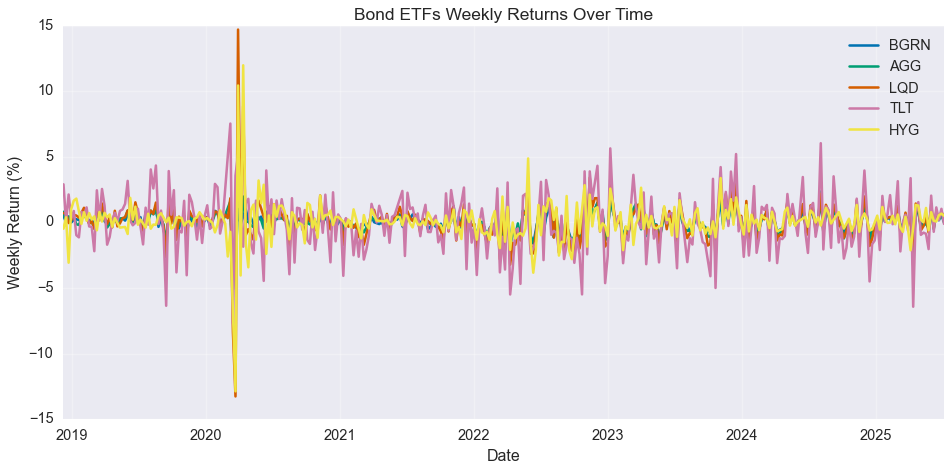

In [259]:
weekly_bond_prices = bond_prices.resample('W').last()
bond_log_returns = weekly_bond_prices.pct_change().dropna() * 100

plt.figure(figsize=(12, 6))

plt.plot(bond_log_returns.index, bond_log_returns['BGRN'], label='BGRN')
plt.plot(bond_log_returns.index, bond_log_returns['AGG'], label='AGG')
plt.plot(bond_log_returns.index, bond_log_returns['LQD'], label='LQD')
plt.plot(bond_log_returns.index, bond_log_returns['TLT'], label='TLT')
plt.plot(bond_log_returns.index, bond_log_returns['HYG'], label='HYG')

plt.title("Bond ETFs Weekly Returns Over Time")
plt.xlabel('Date')
plt.ylabel('Weekly Return (%)')

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plot_path = os.path.join(bgrn_plots, 'bond_weekly_returns_comparison_price_plot.png')
plt.savefig(plot_path)
print(f"Plot saved to {plot_path}")

plt.show()

In [271]:
correlation_matrix = bond_returns.corr(method='kendall')

print(correlation_matrix.round(3))

       BGRN    AGG    LQD    TLT    HYG
BGRN  1.000  0.680  0.638  0.603  0.274
AGG   0.680  1.000  0.762  0.725  0.271
LQD   0.638  0.762  1.000  0.625  0.386
TLT   0.603  0.725  0.625  1.000  0.126
HYG   0.274  0.271  0.386  0.126  1.000


Plot saved to plots\bgrn\bond_correlation_matrix.png


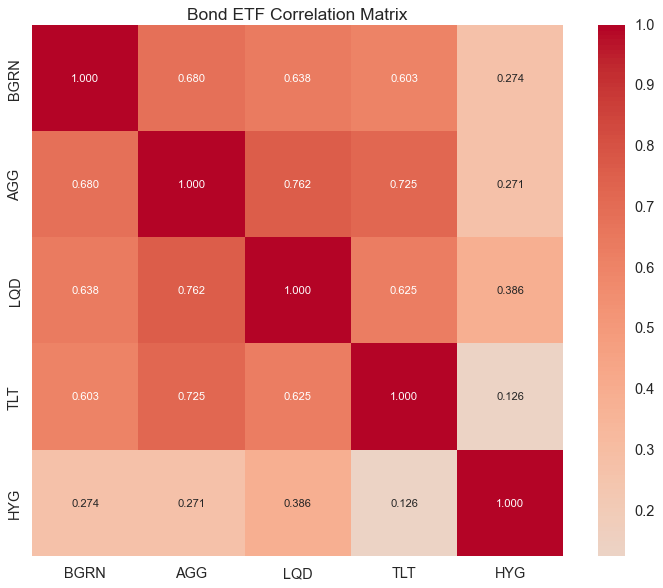

In [272]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f')
plt.title('Bond ETF Correlation Matrix')

plot_path = os.path.join(bgrn_plots, 'bond_correlation_matrix.png')
plt.savefig(plot_path)
print(f"Plot saved to {plot_path}")

plt.show()

Plot saved to plots\bgrn\bond_rolling_correlation_plot.png


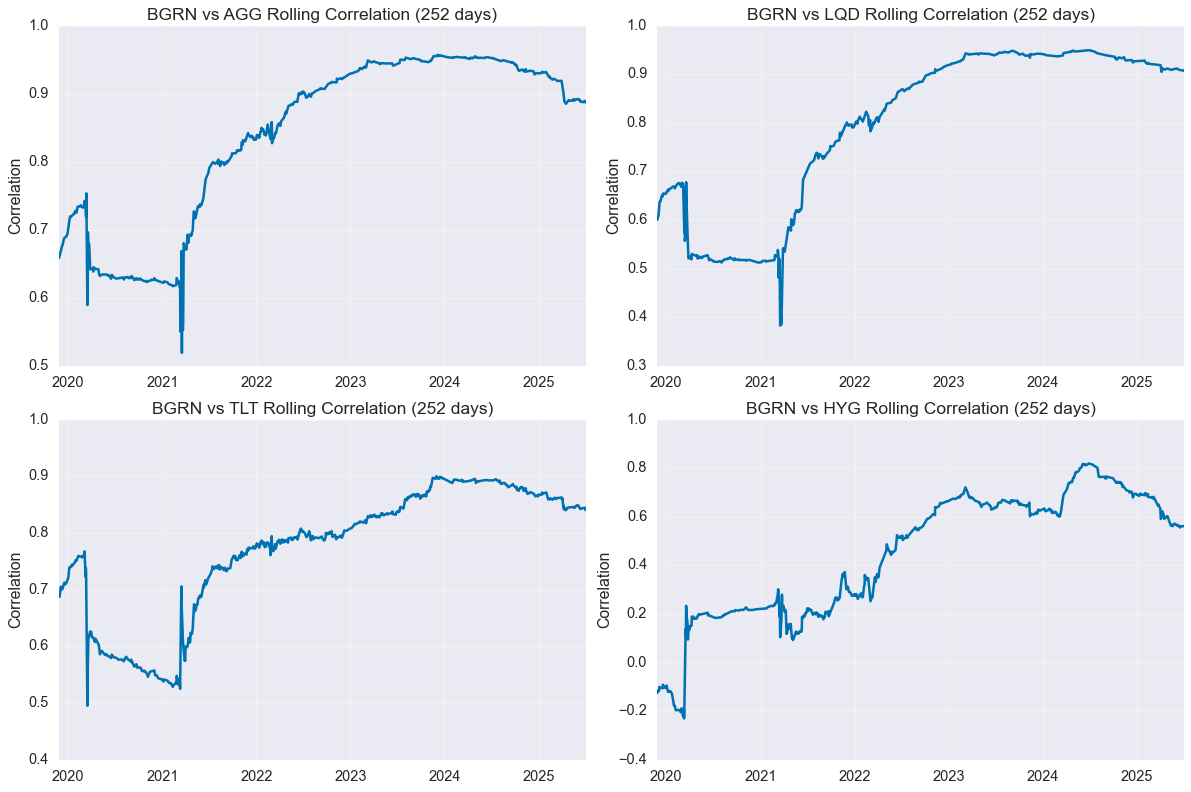

In [262]:
window = 252
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

benchmarks = ['AGG', 'LQD', 'TLT', 'HYG']
for i, benchmark in enumerate(benchmarks):
    row, col = i // 2, i % 2
    rolling_corr = bond_returns['BGRN'].rolling(window).corr(bond_returns[benchmark])
    axes[row, col].plot(rolling_corr.index, rolling_corr.values)
    axes[row, col].set_title(f'BGRN vs {benchmark} Rolling Correlation ({window} days)')
    axes[row, col].grid(True, alpha=0.3)
    axes[row, col].set_ylabel('Correlation')


plot_path = os.path.join(bgrn_plots, 'bond_rolling_correlation_plot.png')
plt.savefig(plot_path)
print(f"Plot saved to {plot_path}")

plt.tight_layout()
plt.show()

As we can see, BGRN behaves like a typical bond ETF. Green bonds don't provide diversification within the bond market. All bonds move together during market stress. It's clear that BGRN has been converging rapidly with other bonds in recent years.

Since all bonds are fundamentally driven by the same force: Federal Reserve monetary policy and interest rate changes, it easily explains why green bonds correlate highly with traditional bond benchmarks.

https://www.investopedia.com/ask/answers/061715/how-bond-yield-affected-monetary-policy.asp

In [263]:
results = {}

for etf in bond_returns.columns:
    returns = bond_returns[etf]
    results[etf] = {
        'Annual_Volatility': returns.std() * np.sqrt(252),
        'Daily_Volatility': returns.std(),
        'Annual_Return': returns.mean() * 252,
        'Sharpe_Ratio': (returns.mean() / returns.std()) * np.sqrt(252),
        'Skewness': stats.skew(returns),
        'Kurtosis': stats.kurtosis(returns),
        'VaR_5%': returns.quantile(0.05),
        'CVaR_5%': returns[returns <= returns.quantile(0.05)].mean(),
        'Max_Drawdown': (returns.cumsum() - returns.cumsum().expanding().max()).min()
    }

pd.DataFrame(results).T

,Annual_Volatility,Daily_Volatility,Annual_Return,Sharpe_Ratio,Skewness,Kurtosis,VaR_5%,CVaR_5%,Max_Drawdown
BGRN,5.219369,0.328789,2.115058,0.405232,0.011753,4.570423,-0.547162,-0.765781,-20.948978
AGG,6.269037,0.394912,2.040009,0.325410,-1.010918,14.902391,-0.574615,-0.900257,-20.045417
LQD,10.157497,0.639862,3.668884,0.361200,0.506007,22.859340,-0.910583,-1.417896,-28.056606
TLT,16.816887,1.059364,-0.145085,-0.008627,0.156728,4.292605,-1.670891,-2.258653,-61.454253
HYG,9.609953,0.605370,5.291092,0.550585,0.109346,22.112304,-0.798328,-1.421009,-24.249741


BGRN and AGG daily volatility is very similar and the annual return is nearly identical. Which further proves the close correlation between two bonds. Other metrics just exist without much need, because there is no need to prove that bond ETFs are low-volatility stocks with small but consistent growth over time.

In [264]:
events = {
    '2020-03-12': 'COVID-19',
    '2022-02-24': 'Russia Invades Ukraine',
    '2022-06-15': 'Fed 75bp Hike',
    '2023-03-10': 'SVB Collapse',
    '2019-12-11': 'EU Green Deal',
}

event_colors = {
    'COVID-19': 'red',
    'Russia Invades Ukraine': 'red',
    'Fed 75bp Hike': 'purple',
    'SVB Collapse': 'orange',
    'EU Green Deal': 'green',
}

event_dates = pd.to_datetime(list(events.keys()))
event_labels = list(events.values())


Price plot saved to plots\bgrn\bgrn_price_with_events.png


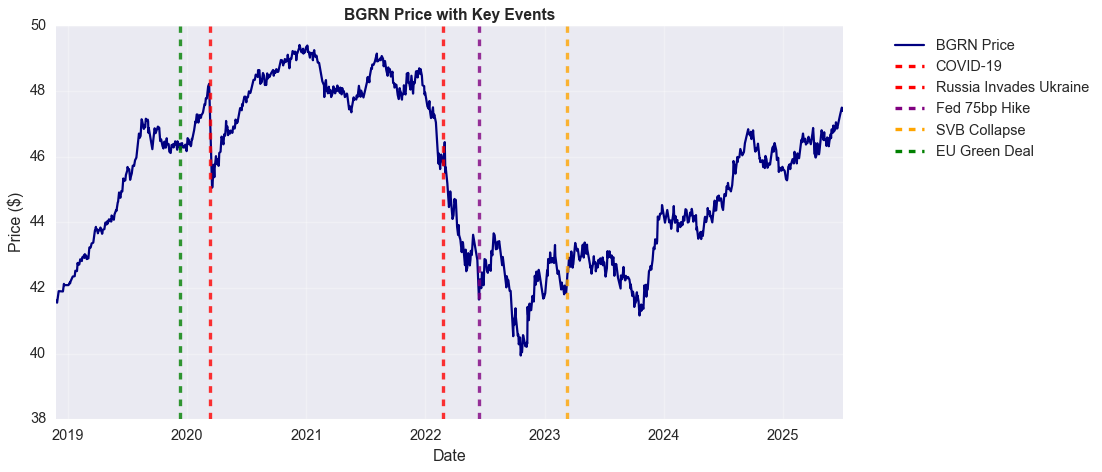

In [265]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(bgrn.index, bgrn[price_col], label='BGRN Price', color='navy', linewidth=2)

legend_handles = []
for date, label in zip(event_dates, event_labels):
    if date >= bgrn.index[0] and date <= bgrn.index[-1]:
        ax.axvline(date, color=event_colors[label], linestyle='--', linewidth=3, alpha=0.8)
        legend_handles.append(Line2D([0], [0], color=event_colors[label], linestyle='--', linewidth=3, label=f"{label}"))

ax.set_title("BGRN Price with Key Events", fontsize=14, fontweight='bold')
ax.set_ylabel("Price ($)")
ax.set_xlabel("Date")
ax.grid(True, alpha=0.3)

ax.legend(handles=[Line2D([0], [0], color='navy', linewidth=2, label='BGRN Price')] + legend_handles,
          bbox_to_anchor=(1.05, 1), loc='upper left')

plot_path_price = os.path.join(bgrn_plots, 'bgrn_price_with_events.png')
plt.savefig(plot_path_price)
print(f"Price plot saved to {plot_path_price}")

plt.tight_layout()
plt.show()

Volatility plot saved to plots\bgrn\bgrn_rolling_volatility_with_events.png


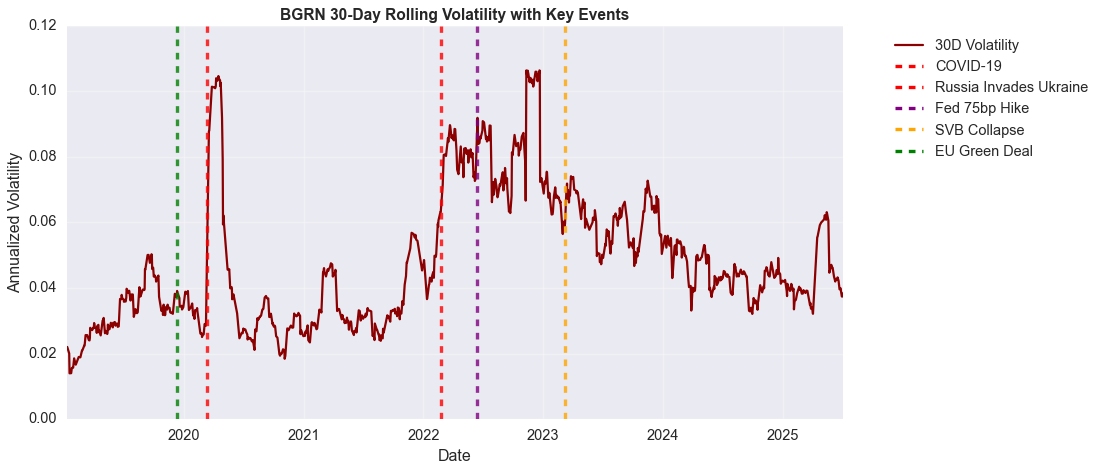

In [266]:
daily_returns = bgrn[price_col].pct_change()
rolling_vol = daily_returns.rolling(30).std() * (252 ** 0.5)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(bgrn.index, rolling_vol, label='30D Volatility', color='darkred', linewidth=2)

legend_handles = []
for date, label in zip(event_dates, event_labels):
    if date >= bgrn.index[0] and date <= bgrn.index[-1]:
        ax.axvline(date, color=event_colors[label], linestyle='--', linewidth=3, alpha=0.8)
        legend_handles.append(Line2D([0], [0], color=event_colors[label], linestyle='--', linewidth=3, label=f"{label}"))

ax.set_title("BGRN 30-Day Rolling Volatility with Key Events", fontsize=14, fontweight='bold')
ax.set_ylabel("Annualized Volatility")
ax.set_xlabel("Date")
ax.grid(True, alpha=0.3)

ax.legend(handles=[Line2D([0], [0], color='darkred', linewidth=2, label='30D Volatility')] + legend_handles,
          bbox_to_anchor=(1.05, 1), loc='upper left')

plot_path_vol = os.path.join(bgrn_plots, 'bgrn_rolling_volatility_with_events.png')
plt.savefig(plot_path_vol)
print(f"Volatility plot saved to {plot_path_vol}")

plt.tight_layout()
plt.show()

Green bonds respond to monetary policy and financial stress, not to green policy events. This directly supports correlation analysis showing BGRN behaves like AGG.